Après le regroupement des visiteurs en quatre clusters par un algorithme d'apprentissage non supervisé, 
on s'intéresse maintenant à prédire le nombre de transactions effectuées par un visiteur en fonction du nombre de vues et 
et du nombre de mises au panier à l'aide d'un modèle de regression linéaire.
On ré-importe les packages et le DataSet "events"

In [1]:
#Les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Lecture du data set 'Events'
events = pd.read_csv('PycharmProjects/Projet-Fil-Rouge/DataSets/events.csv', sep= ',')

#Affichage des 5 premières lignes
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


La variable 'event' est dichotomisée afin de faire ressortir chaque type d'action puis est ajouté au dataframe transac_df

In [3]:
transac_df = events.join(pd.get_dummies(events['event'], prefix_sep='_'))

Les variables d'interêt sont ensuite regroupées dans un nouveau dataset appelé transac_df_summary

In [4]:
transac_df_summary = transac_df.groupby('visitorid').agg({'view': 'sum', 'addtocart': 'sum', 'transaction': 'sum'})

On ne garde que les visiteurs qui ont effectué au moins une transaction sur le site au cours de la période.

In [5]:
transac_df_summary = transac_df_summary[transac_df_summary['transaction'] >= 1]
transac_df_summary.head()

,view,addtocart,transaction
visitorid,,,
172,33.0,3.0,2.0
186,2.0,1.0,1.0
264,3.0,2.0,2.0
419,4.0,1.0,1.0
539,4.0,2.0,1.0


La prédiction par la régression linéaire suppose à priori une relation linéaire entre les variables et une certaine 
corrélation entre elles. Le graphique pairplot ci-dessous confirme l'hypothèse de linéarité entre la variable d'intérêt (nnombre de transactions) et les autres variables explicatives (nombre de vues/mises au panier). Elles sont également très corrélées avec la variable indépendante (coefficient de corrélation très proche de l'unité). Par ailleurs, on détecte une forte multicolinéarité entre les features qui risque de conduire à un sur-apprentissage du modèle.

<Figure size 720x720 with 0 Axes>

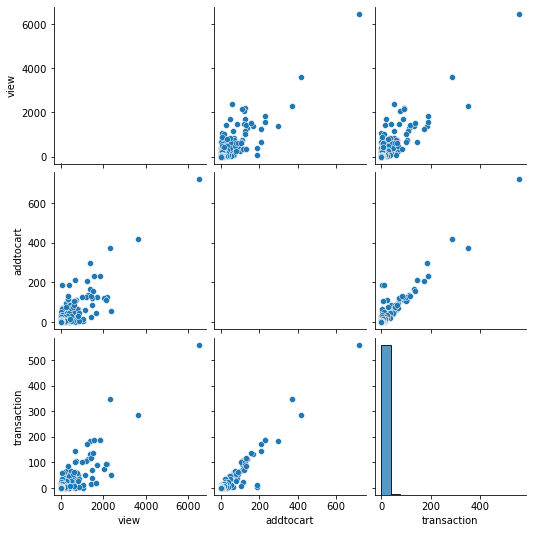

In [6]:
plt.figure(figsize =(10,10))

sns.pairplot(transac_df_summary[['view', 'addtocart', 'transaction']]);

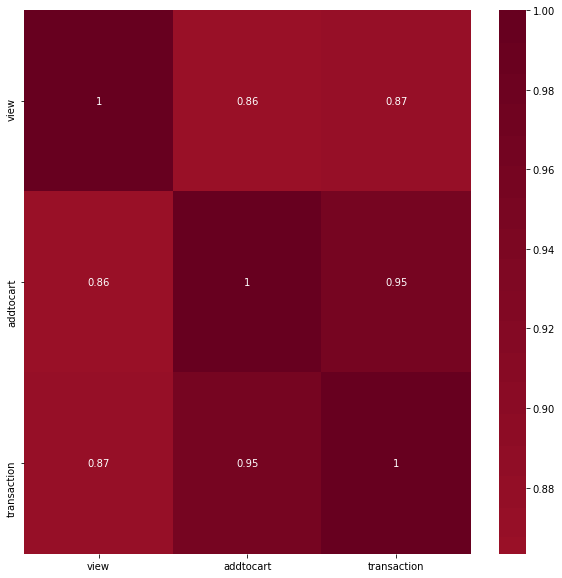

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(transac_df_summary.corr(), annot=True, cmap="RdBu_r", center =0);

In [ ]:
On normalise les données avec la méthode Min-Max

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(transac_df_summary), columns= transac_df_summary.columns)

On stocke la variable 'transaction' de data dans target et le reste des variables dans features. On sépare ensuite les données en un ensemble d'apprentissage et un ensemble de test contenant 20% des données. La reproductibilité de l'aléatoire est fixé à 150.

In [9]:
target = data['transaction']
features = data.drop('transaction', axis =1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 150)

Ajustement du modèle de régression

In [14]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Le modèle de regression linéaire estimé s'écrit : transaction = -0.001258 + 0.221049*view + 0.722688*addtocart. Le nombre de vues et plus encore le nombre de mises au panier augmentent positivement la probabilité de faire une transaction sur le site.

In [15]:
coeffs_reg = list(reg.coef_)
coeffs_reg.insert(0, reg.intercept_)

feats = list(features.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'Coefficient estimé': coeffs_reg}, index = feats)

,Coefficient estimé
intercept,-0.001258
view,0.221049
addtocart,0.722688


Faisons maintenant le diagnostic du modèle au travers de différents tests :ajustement du modèle (coefficient de détermination), analyse des résidus,...)

Les coefficients de détermination obtenus sur les deux échantillons sont très bons et très proches. Le modèle est bien 
ajusté aux données. Toutefois, le R2 obtenu par validation croisée est plus faible laissant présager d'un problème over-fitting.

In [16]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

print("R2 du modèle-échantillon d'entrainement :", reg.score(X_train, y_train))
print("R2 obtenu par Cv :", cross_val_score(reg,X_train,y_train).mean())
print("R2 du modèle-échantillon test :",reg.score(X_test,y_test))

R2 du modèle-échantillon d'entrainement : 0.9169061520023433
R2 obtenu par Cv : 0.7217781731544015
R2 du modèle-échantillon test : 0.9331201785673228


In [ ]:
Analyse des résidus du modèle de régression

In [17]:
from sklearn.metrics import mean_squared_error

reg_pred_train = reg.predict(X_train)
reg_pred_test = reg.predict(X_test)

print("MSE échantillon-entrainement :", mean_squared_error(reg_pred_train, y_train))
print("MSE échantillon-test:", mean_squared_error(reg_pred_test, y_test))

MSE échantillon-entrainement : 2.1955758096655935e-05
MSE échantillon-test: 1.3426653616593717e-05


L'analyse des résidus révèle qu'ils ne sont pas parfaitement disséminés autour de la droite d'équation y=0 que ce soit pour l'échantillon d'entrainement ou de test. Ils sont donc à priori hétérocédastiques. De plus, le diagramme Quantile-Quantile (QQ-Plot) indique clairement que leur distribution ne suit pas une loi normale car ils ne sont pas alignés sur la première bissectrice. 

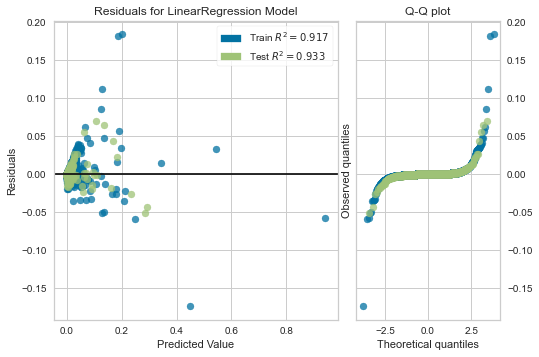

In [18]:
#! pip install yellowbrick : package à installer avant
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(reg, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

In [19]:
#Une autre méthode pour la régression linéaire avec la bibliothèque statsmodels qui donne des résultats très proches 
# de ceux obtenus avec sklearn

import statsmodels.formula.api as smf

regression = smf.ols('transaction ~ view + addtocart', data = data)
res = regression.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            transaction   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 6.744e+04
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:09:14   Log-Likelihood:                 46739.
No. Observations:               11719   AIC:                        -9.347e+04
Df Residuals:                   11716   BIC:                        -9.345e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0013   4.23e-05    -30.133      0.0

Conclusion : le modèle est certes bien ajusté aux données (R2 > 90 %), mais il ne possède pas de bonnes propriétés statistiques (résidus hétérocédastiques et non normaux). De plus, il présente des signes de sur-apprentissage probablement dus à la multicolinéarité entre les variables explicatives.

*---------------------------------------------------------------------------------------------------------------------*

Grâce à la régression régularisée, on peut corriger cet effet de sur-apprentissage dans le modèle. On se propose de tester trois algorithmes (la régression ridge, la régression Lasso et la régression ElasticNet) sur des données qui auront été préalablement standardisées.

*---Régression Ridge---*

On commence par normaliser les variables en utilisant la méthode StandardScaler de la classe sklearn.preprocessing

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(transac_df_summary), columns= transac_df_summary.columns)

On isole la variable cible (target2) et les variables explicatives (features2) on scinde les données en deux échantillons. L'échantillon test représente 20% de l'ensemble des observations; la reproductibilité de l'aléatoire est fixé à 280.

In [21]:
target2 = data_scaled['transaction']
features2 = data_scaled.drop('transaction', axis =1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features2, target2, test_size=0.2, random_state = 280)

Nous allons utiliser la classe RidgeCV qui par validation croisée permettra de trouver le meilleur modèle prédictif. Différentes valeurs de alpha (coefficient de pénalité) seront testés pour trouver celle qui minimise le critère d'erreur.

In [22]:
from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas= (0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30, 50))
ridge_reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.0e-03, 5.0e-02, 1.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 7.0e-01,
       1.0e+00, 5.0e+00, 1.0e+01, 1.5e+01, 3.0e+01, 5.0e+01]))

In [24]:
coeffs_ridge = list(ridge_reg.coef_)
coeffs_ridge.insert(0, ridge_reg.intercept_)

feats = list(features.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'Coefficient estimé': coeffs_ridge}, index = feats)

,Coefficient estimé
intercept,-0.001303
view,0.186705
addtocart,0.768730


La valeur optimale de alpha qui minimise le critère d'erreur est de 0.001. Le modèle affiche de très bonnes performances à la fois sur l'échantillon d'entrainement que sur l'échantillon test. Le score sur l'échantillon d'entrainement obtenu avec la régression rigde s'est légèrement améliorée par rapport à la régression linéaire, mais sur l'échantillon test il a regressé (87.7% contre 93.3% auparavant).

In [25]:
print( "Valeur optimal de alpha :" ,ridge_reg.alpha_)
print("Score échantillon-entrainement :", ridge_reg.score(X_train, y_train))
print("Score obtenu par Cv :", cross_val_score(ridge_reg,X_train,y_train).mean())
print("Score échantillon-test :", ridge_reg.score(X_test, y_test))

Valeur optimal de alpha : 0.001
Score échantillon-entrainement : 0.9343477476135365
Score obtenu par Cv : 0.8202125801817377
Score échantillon-test : 0.87692386259216


Analysons l'erreur quadratique moyenne de prédiction sur les deux échantillons.

In [26]:
from sklearn.metrics import mean_squared_error

ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

print("MSE échantillon-entrainement :", mean_squared_error(ridge_pred_train, y_train))
print("MSE échantillon-test:", mean_squared_error(ridge_pred_test, y_test))

MSE échantillon-entrainement : 0.06078056910110858
MSE échantillon-test: 0.15956248989003244


Conclusion : L'erreur quadratique moyenne de prédiction sur l'échantillon d'entrainement est deux fois moindre que sur l'échantillon test. Avec son coeffcient de détermination qui est aussi plus élevé, on peut déduire que le sur-aprentissage persiste sur l'échantillon d'entrainement.

*---Régression Lasso---*

In [ ]:
Déterminons la valeur optimale de alpha par validation croisée à partir de la classe LassoCV

In [27]:
from sklearn.linear_model import LassoCV

lasso_reg = LassoCV(alphas = [0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30, 50], cv = 10)
lasso_reg.fit(X_train, y_train)

LassoCV(alphas=[0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30, 50],
        cv=10)

In [28]:
coeffs_lasso = list(lasso_reg.coef_)
coeffs_lasso.insert(0, lasso_reg.intercept_)

feats = list(features.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'Coefficient estimé': coeffs_lasso}, index = feats)

,Coefficient estimé
intercept,-0.001307
view,0.186613
addtocart,0.767782


La valeur optimale de alpha qui minimise le critère d'erreur est de 0.001. La régression Lasso conduit à un modèle avec les mêmes performances que celui obtenu avec la régression Ridge : un score légèrement plus élevé avec l'échantillon d'entrainement qu'avec l'échantillon test.

In [29]:
print("Valeur optimale de alpha :", lasso_reg.alpha_)
print("Score échantillon-entrainement :", lasso_reg.score(X_train, y_train))
print("Score obtenu par Cv :", cross_val_score(lasso_reg,X_train,y_train).mean())
print("Score échantillon-test :", lasso_reg.score(X_test, y_test))

Valeur optimale de alpha : 0.001
Score échantillon-entrainement : 0.9343466286938873
Score obtenu par Cv : 0.820596761230075
Score échantillon-test : 0.8767269912766635


L'erreur quadratique moyenne de prédiction sur l'échantillon d'entrainement est aussi deux plus élevé que sur l'échantillon test.

In [30]:
from sklearn.metrics import mean_squared_error

lasso_pred_train = lasso_reg.predict(X_train)
lasso_pred_test = lasso_reg.predict(X_test)

print("MSE échantillon-entrainement :", mean_squared_error(lasso_pred_train, y_train))
print("MSE échantillon-test:", mean_squared_error(lasso_pred_test, y_test))

MSE échantillon-entrainement : 0.060781604992042666
MSE échantillon-test: 0.15981772439730701


In [ ]:
Les propriétés statistiques des résidus ne se sont pas améliorés avec les deux modèles.

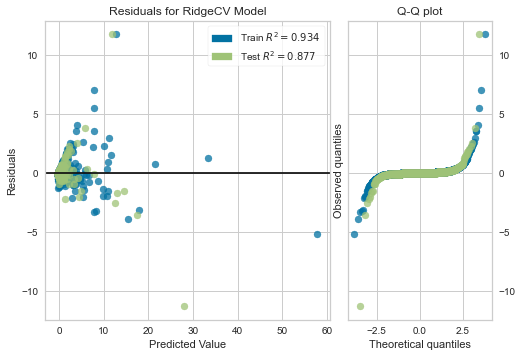

In [31]:
visualizer_ridge = ResidualsPlot(ridge_reg, hist=False, qqplot=True)
visualizer_ridge.fit(X_train, y_train)
visualizer_ridge.score(X_test, y_test)
visualizer_ridge.show();

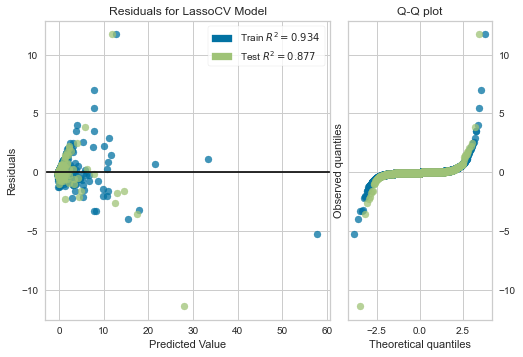

In [32]:
visualizer_lasso = ResidualsPlot(lasso_reg, hist=False, qqplot=True)
visualizer_lasso.fit(X_train, y_train)
visualizer_lasso.score(X_test, y_test)
visualizer_lasso.show();

*---Régression ElaticNet---*

Les méthodes de régression Ridge et Lasso n'ont pas permis pour l'instant de trouver le meilleur modèle. Nous nous proposons de tester la méthode ElasticNet qui, par construction, combine les coefficients de pénalités des régressions précédentes.

In [33]:
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV(cv=12, l1_ratio = (0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30, 50,70), 
                        alphas= (0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30, 50))
model_en.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30,
                     50),
             cv=12,
             l1_ratio=(0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 10, 15, 30,
                       50, 70))

In [34]:
coeffs_en = list(model_en.coef_)
coeffs_en.insert(0, model_en.intercept_)

feats = list(features.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'Coefficient estimé': coeffs_en}, index = feats)

,Coefficient estimé
intercept,-0.001315
view,0.188946
addtocart,0.765867


In [ ]:
Les performances du modèle prédictif sont également identiques.

In [35]:
print("Valeur optimale de alpha :", model_en.alpha_)
print("Score échantillon-entrainement :", model_en.score(X_train, y_train))
print("Score obtenu par Cv :", cross_val_score(model_en,X_train,y_train).mean())
print("Score échantillon-test :", model_en.score(X_test, y_test))

Valeur optimale de alpha : 0.001
Score échantillon-entrainement : 0.934345832469382
Score obtenu par Cv : 0.8204749333252874
Score échantillon-test : 0.8767333929422961


In [36]:
elasCV_pred_train = model_en.predict(X_train)
elasCV_pred_test = model_en.predict(X_test)

print("MSE échantillon-entrainement :", mean_squared_error(elasCV_pred_train, y_train))
print("MSE échantillon-test:", mean_squared_error(elasCV_pred_test, y_test))

MSE échantillon-entrainement : 0.06078234213321921
MSE échantillon-test: 0.15980942493545122


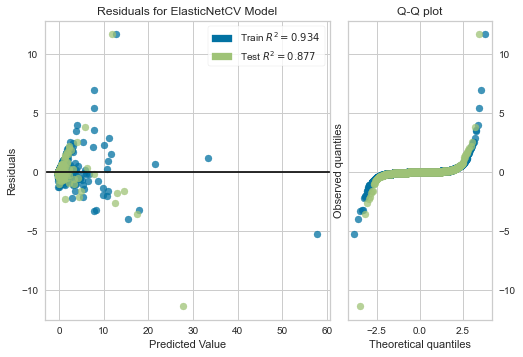

In [37]:
visualizer_elasCV = ResidualsPlot(model_en, hist=False, qqplot=True)
visualizer_elasCV.fit(X_train, y_train)
visualizer_elasCV.score(X_test, y_test)
visualizer_elasCV.show();

Conclusion : La régression Ridge a sensiblement amélioré le modèle par rapport aux modèles. Elle a dans un premier temps renforcé l'influence de la variable 'addtocart' comme facteur explicatif principal des transactions. Elle a augmenté sensiblement la performance du modèle sur l'échantillon test qui est passé de 87.2% à 87.7%. L'erreur de prédiction a chuté considérablement pour les deux échantillons quoique l'écart entre les deux persiste.

In [39]:
#Les coefficients des paramètres estimés
pd.DataFrame({'Régression linéaire': coeffs_reg, 
              'Régression Ridge': coeffs_ridge,
              'Régression Lasso': coeffs_lasso,
              'Régression ElasticNet': coeffs_en}, index = feats)

,Régression linéaire,Régression Ridge,Régression Lasso,Régression ElasticNet
intercept,-0.001258,-0.001303,-0.001307,-0.001315
view,0.221049,0.186705,0.186613,0.188946
addtocart,0.722688,0.768730,0.767782,0.765867


In [43]:
#Les performances
pd.DataFrame({'Régression linéaire': (reg.score(X_train, y_train), cross_val_score(reg,X_train,y_train).mean(),reg.score(X_test,y_test)), 
              'Régression Ridge': (ridge_reg.score(X_train, y_train), cross_val_score(ridge_reg,X_train,y_train).mean(), ridge_reg.score(X_test, y_test)),
              'Régression Lasso': (lasso_reg.score(X_train, y_train),cross_val_score(lasso_reg,X_train,y_train).mean(),lasso_reg.score(X_test, y_test)),
              'Régression ElasticNet': (model_en.score(X_train, y_train),cross_val_score(model_en,X_train,y_train).mean(),model_en.score(X_test, y_test))}, index = ['Train', 'C-V','Test'])

,Régression linéaire,Régression Ridge,Régression Lasso,Régression ElasticNet
Train,0.933838,0.934348,0.934347,0.934346
C-V,0.820445,0.820213,0.820597,0.820475
Test,0.872897,0.876924,0.876727,0.876733


In [44]:
#Les erreurs de prédiction
pd.DataFrame({'Régression linéaire': (mean_squared_error(reg_pred_train, y_train),mean_squared_error(reg_pred_test, y_test)), 
              'Régression Ridge': (mean_squared_error(ridge_pred_train, y_train), mean_squared_error(ridge_pred_test, y_test)),
              'Régression Lasso': ( mean_squared_error(lasso_pred_train, y_train),mean_squared_error(lasso_pred_test, y_test) ),
              'Régression ElasticNet': (mean_squared_error(elasCV_pred_train, y_train),mean_squared_error(elasCV_pred_test, y_test))}, index = ['Train','Test'])

,Régression linéaire,Régression Ridge,Régression Lasso,Régression ElasticNet
Train,0.926039,0.060781,0.060782,0.060782
Test,1.296775,0.159562,0.159818,0.159809
